### Notebook to configure model

In [1]:
import time
import math
import copy

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context(context="talk")

import torch
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils import data


/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
isRetrain = False


# Hyperparameter

QUERY_SIZE = 1
EMBEDDING_SIZE = 50

# HIDDEN_SIZE = 512
# ATTENTION_SIZE = 64

LEARNING_RATE = 5*1e-3
BATCH_SIZE = 500
LAMBDA = 1e-5

VOCAB_SIZE = 5
NUM_CLASSES = 2

# Data-specific

READ_LENGTH = 100

# # KRAS
# GENOME_START = 25204789
# GENOME_END = 25250936

# # NOTCH1
# GENOME_START = 136494433 
# GENOME_END = 136545786

# NRAS
file_name = 'NRAS'
GENOME_START = 114704464 
GENOME_END = 114716894

GENOME_LENGTH = GENOME_END - GENOME_START + 1  
CONTEXT_SIZE = GENOME_LENGTH

ref_names = ["class", "ref", "sequence"]
VOCAB = ['N','A','T','C','G']



In [3]:
def load_ref_data(file_name, sample_ratio= 1, n_class=2, names=ref_names):
    
    csv_file = pd.read_csv(file_name, names=ref_names)
    shuffle_csv = csv_file.sample(frac=sample_ratio).reset_index()
#     x = pd.Series(shuffle_csv["sequence"])
    x = list(shuffle_csv["sequence"])
#     ref = pd.Series(shuffle_csv["ref"])
    ref = list(shuffle_csv["ref"])
    y = pd.Series(shuffle_csv["class"])
    y = to_one_hot(y, n_class)
    print(y.shape)
#     print(type(x))
#     print(type(y))
#     print(type(ref))

    return x, ref, y


In [4]:
def create_synthetic_data(file_name, cancer_genes, benign_genes, num_patients=10, num_reads_per_patients=3, read_length=READ_LENGTH, genome_length=GENOME_LENGTH, vocab=VOCAB, isSomatic=True, print_seq=False):
    
    seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    backup_seq_list = seq_list
    
    for loc, mutation in cancer_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)

    file = open('./tumor-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./tumor-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1, %d, %s\n" % (locs[r], reads[r]))
    file.close()
    
    tumor_locs = locs
    tumor_reads = reads

    if isSomatic:
        seq_list = backup_seq_list
    else:
        seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    
    for loc, mutation in benign_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)
    
    file = open('./normal-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./normal-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("0, %d, %s\n" % (locs[r], reads[r]))
    file.close() 
    
    normal_locs = locs
    normal_reads = reads
    
    file = open('./syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1,%d,%s\n" % (tumor_locs[r], tumor_reads[r]))
        file.write("0,%d,%s\n" % (normal_locs[r], normal_reads[r]))
    file.close() 
    
    return './syn-'+file_name+'.csv'
    
    
    

In [5]:
def to_one_hot(y, n_class):
    
    return np.eye(n_class)[y.astype(int)]


In [6]:
def split_ref_dataset(x_test, y_test, ref_test, dev_ratio):

    test_size = len(x_test)
    print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    print(dev_size)

    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    ref_dev = ref_test[:dev_size]
    ref_test = ref_test[dev_size:]

    return x_test, x_dev, y_test, y_dev, ref_test, ref_dev, dev_size, test_size - dev_size


In [7]:
class TensorizedReadDataset(torch.utils.data.DataLoader):
    'Characterizes a Tensorized dataset for genome reads in PyTorch'
    
    def __init__(self, reads, ref_locs, labels, read_length=100, genome_start=0, genome_end=0):
#         super(TensorizedReadDataset, self).__init__()
        
        # self.read_length = read_length
        self.labels = labels
        self.reads = reads
        self.ref_locs = ref_locs
        self.genome_start = genome_start
        self.genome_end = genome_end

    def __len__(self):
        return len(self.reads)

    def __getitem__(self, index):
        
        vals = list(self.reads[index])
        read_length = len(vals)
        locs = list(np.arange(self.ref_locs[index]-self.genome_start,self.ref_locs[index]+read_length-self.genome_start))

#         print(len(vals))
#         print(len(locs))
        
        vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}
#         read = torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int), requires_grad=False)

        read = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int)), requires_grad=False)
        
        X = read
        Y = self.labels[index,:]

#         torch.LongTensor(self.labels[index,:])

        return X, Y
    

In [8]:
class SequenceAttentionClassifier(nn.Module):
    
    def __init__(self, genome_length, vocab_size=5, query_size=10, embedding_size=128, num_classes=2):
        
        super(SequenceAttentionClassifier, self).__init__()
        
        self.genome_length = genome_length
        self.vocab_size = vocab_size
        self.query_size = query_size
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.K = nn.Embedding(vocab_size*genome_length, embedding_size)
        self.V = nn.Embedding(vocab_size*genome_length, query_size)
        self.W = nn.Linear(query_size, num_classes)
        self.Q = nn.Linear(embedding_size, query_size)
        
    def forward(self, read):
        
        # 'read' here should be mapped to a flattened form where X_ij = 1 maps to i*vocab_size + j
        K_lookup = self.K(read) # Get the relevant keys
        V_lookup = self.V(read) # Get the relevant values

        # Get the attention weights
        logits = self.Q(K_lookup) / math.sqrt(self.embedding_size)
        probs = F.softmax(logits, dim = 0)
        
        # Calculate the covariates for the logistic regression
#         X = torch.matmul(probs.transpose(1,2), V_lookup)
#         X = probs * V_lookup
        X = (probs * V_lookup).sum(dim=1)

        # Right now we can just ignore the fact that we're doing a linear-transform.
        # In the future we'll add nonlinearities

        # Return the logits for the classifier
        return self.W(X), K_lookup, V_lookup
    

In [9]:
def GetTensorBatch(reads, ref_locs, labels, batch_size=100, genome_start=0, genome_end=0):
      
    batches = {}
    set_size = len(ref_locs)
    for batch in range(set_size // batch_size):
        
        x_batch = []
        y_batch = []
        
        for index in range(batch_size):
        
            vals = list(reads[index])
            read_length = len(vals)
            locs = list(np.arange(ref_locs[index]-genome_start,ref_locs[index]+read_length-genome_start))
        
            vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}
            read = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int)), requires_grad=False)
        
            X = read
            Y = labels[index,:]
            x_batch.append(X)
            y_batch.append(Y)
        
        batches[batch] = [x_batch, y_batch]

    return batches
    

In [14]:
# load data

x_train, refs_train, y_train = load_ref_data("../data/data/ref-germline-NRAS-train39000.csv", sample_ratio=1)
x_test, refs_test, y_test = load_ref_data("../data/data/ref-germline-NRAS-test1000.csv", sample_ratio=1)

# split dataset to test and dev
x_train, x_softval, y_train, y_softval, refs_train, refs_softval, softval_size, train_size = split_ref_dataset(x_train, y_train, refs_train, 0.02)
    
print("Soft Validation size: ", softval_size)
print("Training size: ", train_size)
print("Test size: ", len(y_test))


(78000, 2)
(2000, 2)
78000
1560
Soft Validation size:  1560
Training size:  76440
Test size:  2000


In [15]:
# Generators
# train_dataset = TensorizedReadDataset(reads=x_train, 
#                                       ref_locs=refs_train, 
#                                       labels=y_train, 
#                                       read_length=READ_LENGTH, 
#                                       genome_start=GENOME_START, 
#                                       genome_end=GENOME_END)

# hardval_dataset = TensorizedReadDataset(reads=x_test, 
#                                         ref_locs=refs_test, 
#                                         labels=y_test, 
#                                         read_length=READ_LENGTH, 
#                                         genome_start=GENOME_START, 
#                                         genome_end=GENOME_END)

# softval_dataset = TensorizedReadDataset(reads=x_softval, 
#                                         ref_locs=refs_softval, 
#                                         labels=y_softval, 
#                                         read_length=READ_LENGTH, 
#                                         genome_start=GENOME_START, 
#                                         genome_end=GENOME_END)

# # Input pipeline
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            shuffle=True)

# hardval_loader = torch.utils.data.DataLoader(dataset=hardval_dataset,
#                                              batch_size=BATCH_SIZE,
#                                              shuffle=True)

# softval_loader = torch.utils.data.DataLoader(dataset=softval_dataset,
#                                              batch_size=BATCH_SIZE,
#                                              shuffle=True)

train_loader = GetTensorBatch(reads=x_train, 
                                      ref_locs=refs_train, 
                                      labels=y_train, 
                                      batch_size=BATCH_SIZE,
                                      genome_start=GENOME_START, 
                                      genome_end=GENOME_END)

hardval_loader = GetTensorBatch(reads=x_test, 
                                        ref_locs=refs_test, 
                                        labels=y_test, 
                                        batch_size=BATCH_SIZE, 
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)

softval_loader = GetTensorBatch(reads=x_softval, 
                                        ref_locs=refs_softval, 
                                        labels=y_softval, 
                                        batch_size=BATCH_SIZE,
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)

test_loader = softval_loader

In [16]:
# isRetrain = True

In [17]:
model = SequenceAttentionClassifier(genome_length=GENOME_LENGTH,

                                    vocab_size=VOCAB_SIZE,
                                    query_size=QUERY_SIZE,
                                    embedding_size=EMBEDDING_SIZE,
                                    num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

if isRetrain:
    model.load_state_dict(torch.load('./'+file_name+'_model.pth'))

In [18]:
acc_each_epoch = []

loss_each_batch = []
acc_each_batch = []
lam = LAMBDA

num_epochs = 10

# Training process
for epoch in range(num_epochs):
#     b = 0 # count batch
    for b, [x_batch, y_batch] in train_loader.items():
        
        full_loss = 0
        optimizer.zero_grad()
        for c in range(BATCH_SIZE):
            
            x_input = x_batch[c].view(1, x_batch[c].shape[0])
            y_input = torch.Tensor(y_batch[c]).type(torch.float64).view(1, y_batch[c].shape[0])
        
            outputs, K, V = model(x_input)
            data_loss = criterion(outputs, torch.max(y_input, 1)[1])
            
            reg_loss = (torch.norm(K,2,1).mean() + torch.norm(V,2,1).mean())*lam
            loss = data_loss + reg_loss
            full_loss = full_loss + loss
        
#         full_loss = full_loss / 2
        full_loss.backward()
        optimizer.step()
        
        if (b + 1) % 1 == 0:
            print("Epoch {}, Batch {}, loss :{}".format(epoch + 1, b + 1, full_loss.data[0]))
#         b = b + 1
        
        loss_each_batch.append(full_loss)
        
        correct = 0
        total = 0
        for b, [x_batch, y_batch] in test_loader.items():
            for c in range(BATCH_SIZE):
                
                x_input = x_batch[c].view(1, x_batch[c].shape[0])
                y_input = torch.Tensor(y_batch[c]).type(torch.float64).view(1, y_batch[c].shape[0])
                
                outputs, K, V = model(x_input)
                _, predicted = torch.max(outputs.data, 1)
                total += len(y_input)
                correct += (predicted == torch.max(y_input.type(torch.LongTensor), 1)[1]).sum()
        acc = int(correct) / total
        print('Soft Validation Accuracy: {}%'.format(100 * acc))   
        acc_each_epoch.append(acc)
    
    correct = 0
    total = 0
    for b, [x_batch, y_batch] in test_loader.items():
        for c in range(BATCH_SIZE):
            
            x_input = x_batch[c].view(1, x_batch[c].shape[0])
            y_input = torch.Tensor(y_batch[c]).type(torch.float64).view(1, y_batch[c].shape[0])
            
            outputs, K, V = model(x_input)
            _, predicted = torch.max(outputs.data, 1)
            total += len(y_input)
            correct += (predicted == torch.max(y_input.type(torch.LongTensor), 1)[1]).sum()
    acc = int(correct) / total
    print('Soft Validation Accuracy: {}%'.format(100 * acc))   
    acc_each_epoch.append(acc)



/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 1, loss :568.371337890625
Soft Validation Accuracy: 51.800000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 2, loss :44920.515625
Soft Validation Accuracy: 46.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 3, loss :32615.28125
Soft Validation Accuracy: 53.2%


KeyboardInterrupt: 

In [202]:
torch.save(model, './full_'+file_name+'_model.pt')
torch.save(model.state_dict(), './'+file_name+'_model.pth')


/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
plt.rcParams['figure.figsize'] = [30, 5]

plt.plot(np.arange(len(loss_each_batch))+1, loss_each_batch)
plt.xlim(1, len(loss_each_batch))
plt.title('loss vs. batchs')
plt.show()

plt.plot(np.arange(len(acc_each_batch))+1, acc_each_batch)
plt.xlim(1, len(acc_each_batch))
plt.title('accuracy vs. batchs')
plt.show()

plt.plot(np.arange(len(acc_each_epoch))+1, acc_each_epoch)
plt.xlim(1, len(acc_each_epoch))
plt.title('accuracy vs. epochs')
plt.show()


In [10]:
model = torch.load('./full_'+file_name+'_model.pt')
# model.load_state_dict(torch.load('./'+file_name+'_model.pth'))


/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [16]:

correct = 0
total = 0
for b, [x_batch, y_batch] in test_loader.items():
    for c in range(BATCH_SIZE):
    
        x_input = x_batch[c].view(1, x_batch[c].shape[0])
        y_input = torch.Tensor(y_batch[c]).type(torch.float64).view(1, y_batch[c].shape[0])
            
        outputs, K, V = model(x_input)
        _, predicted = torch.max(outputs.data, 1)
        total += len(y_input)
        correct += (predicted == torch.max(y_input.type(torch.LongTensor), 1)[1]).sum()
acc = int(correct) / total
print('Soft Validation Accuracy: {}%'.format(100 * acc))   


correct = 0
total = 0
for b, [x_batch, y_batch] in hardval_loader.items():
    for c in range(BATCH_SIZE):
        
        x_input = x_batch[c].view(1, x_batch[c].shape[0])
        y_input = torch.Tensor(y_batch[c]).type(torch.float64).view(1, y_batch[c].shape[0])
            
        outputs, K, V = model(x_input)
        _, predicted = torch.max(outputs.data, 1)
        total += len(y_input)
        correct += (predicted == torch.max(y_input.type(torch.LongTensor), 1)[1]).sum()
acc = int(correct) / total
print('Hard Validation Accuracy: {}%'.format(100 * acc))



Hard validation Accuracy: 51%
Soft validation Accuracy: 49%


In [11]:
genome_locs = list(np.arange(0,GENOME_LENGTH))
vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}

genome_N_vals = ['N'] * GENOME_LENGTH
genome_A_vals = ['A'] * GENOME_LENGTH
genome_C_vals = ['C'] * GENOME_LENGTH
genome_T_vals = ['T'] * GENOME_LENGTH
genome_G_vals = ['G'] * GENOME_LENGTH

genome_N = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_N_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_A = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_A_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_C = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_C_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_T = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_T_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_G = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_G_vals, genome_locs)], dtype=int)), requires_grad=False)



In [12]:
# for plotting

q_size = model.query_size
# q_size = 1
point_size = 50
alpha_value = 1
width = 30
height = 5

torch.Size([205438, 20])
torch.Size([205438, 2])
torch.Size([205438, 20])


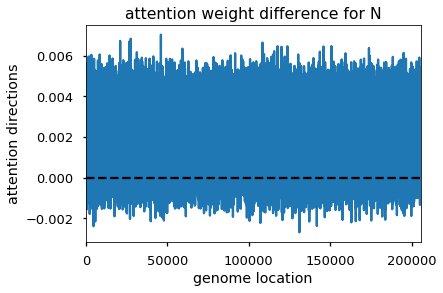

In [13]:
K_lookup_N = model.K(genome_N) 
V_lookup_N = model.V(genome_N) 
logits_N = model.Q(K_lookup_N) / math.sqrt(model.embedding_size)
probs_N = F.softmax(logits_N, dim = -1)    
X_N = probs_N * V_lookup_N
Y_N = model.W(X_N)

print(probs_N.shape)
print(Y_N.shape)
print(logits_N.shape)

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention weights')
# plt.title('QK attention weights for N')
# # plt.savefig('./N-attn-'+file_name+'.png')
# plt.show()

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('QKV attention weights for N')
# # plt.savefig('./N-Vatt-'+file_name+'.png')
# plt.show()

# for q in range(2):
#     plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,q], s=point_size, alpha=alpha_value)
# plt.legend({'normal','tumor'})
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('attention direction for N')
# # plt.savefig('./N-dirc-'+file_name+'.png')
# plt.show()

# plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.plot(np.arange(GENOME_LENGTH), list(Y_N.data[:,0]-Y_N.data[:,1]))
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for N')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./N-diff-'+file_name+'.png')
plt.show()


torch.Size([205438, 20])
torch.Size([205438, 2])


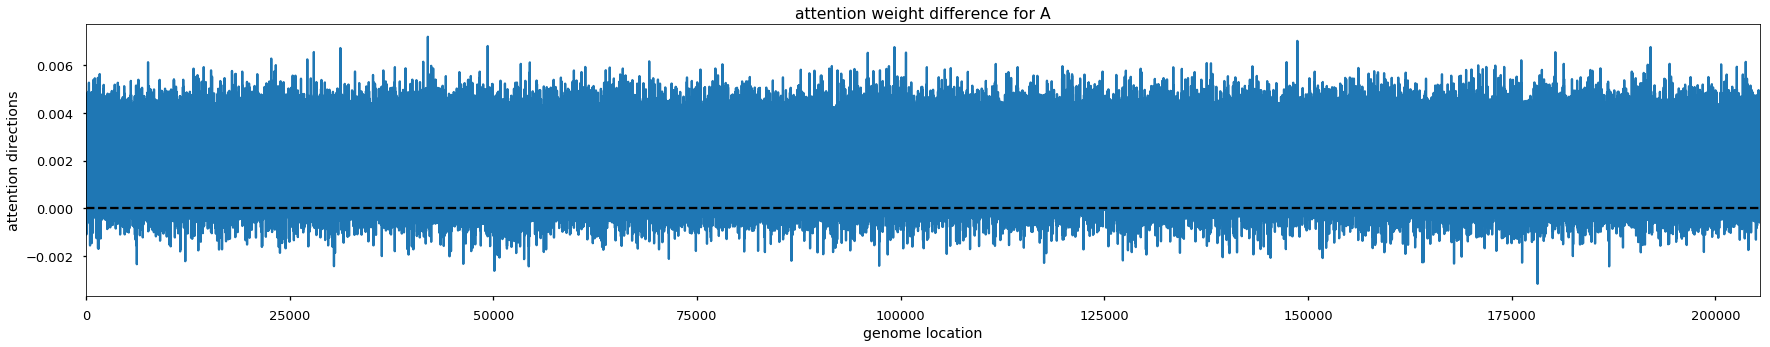

In [21]:
K_lookup_A = model.K(genome_A) 
V_lookup_A = model.V(genome_A) 
logits_A = model.Q(K_lookup_A) / math.sqrt(model.embedding_size)
probs_A = F.softmax(logits_A, dim = -1)    
X_A = probs_A * V_lookup_A
Y_A = model.W(X_A)

print(probs_A.shape)
print(Y_A.shape)

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention weights')
# plt.title('QK attention weights for A')
# plt.savefig('./A-attn-'+file_name+'.png')
# plt.show()

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('QKV attention weights for A')
# # plt.savefig('./A-Vatt-'+file_name+'.png')
# plt.show()

# for q in range(2):
#     plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,q], s=point_size, alpha=alpha_value)
# plt.legend({'normal','tumor'})
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('attention direction for A')
# plt.savefig('./A-dirc-'+file_name+'.png')
# plt.show()

# plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.plot(np.arange(GENOME_LENGTH), list(Y_A.data[:,0]-Y_A.data[:,1]))
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for A')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./A-diff-'+file_name+'.png')
plt.show()



torch.Size([205438, 20])
torch.Size([205438, 2])


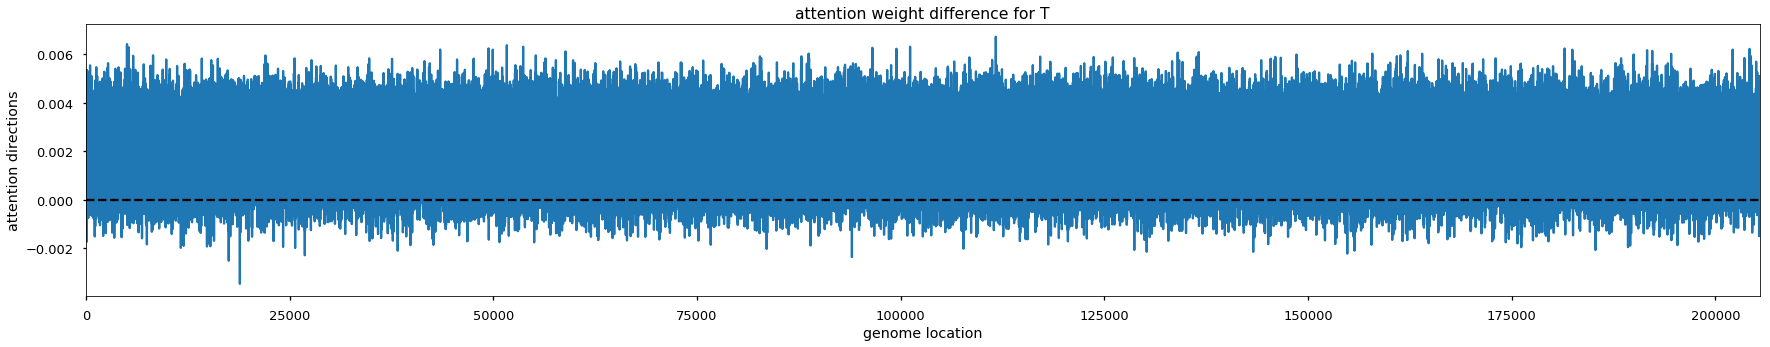

In [22]:
K_lookup_T = model.K(genome_T) 
V_lookup_T = model.V(genome_T) 
logits_T = model.Q(K_lookup_T) / math.sqrt(model.embedding_size)
probs_T = F.softmax(logits_T, dim = -1)    
X_T = probs_T * V_lookup_T
Y_T = model.W(X_T)

print(probs_T.shape)
print(Y_T.shape)

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention weights')
# plt.title('QK attention weights for T')
# plt.savefig('./T-attn-'+file_name+'.png')
# plt.show()

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('QKV attention weights for T')
# # plt.savefig('./T-Vatt-'+file_name+'.png')
# plt.show()

# for q in range(2):
#     plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,q], s=point_size, alpha=alpha_value)
# plt.legend({'normal','tumor'})
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('attention direction for T')
# plt.savefig('./T-dirc-'+file_name+'.png')
# plt.show()

# plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.plot(np.arange(GENOME_LENGTH), list(Y_T.data[:,0]-Y_T.data[:,1]))
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for T')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./T-diff-'+file_name+'.png')
plt.show()


torch.Size([205438, 20])
torch.Size([205438, 2])


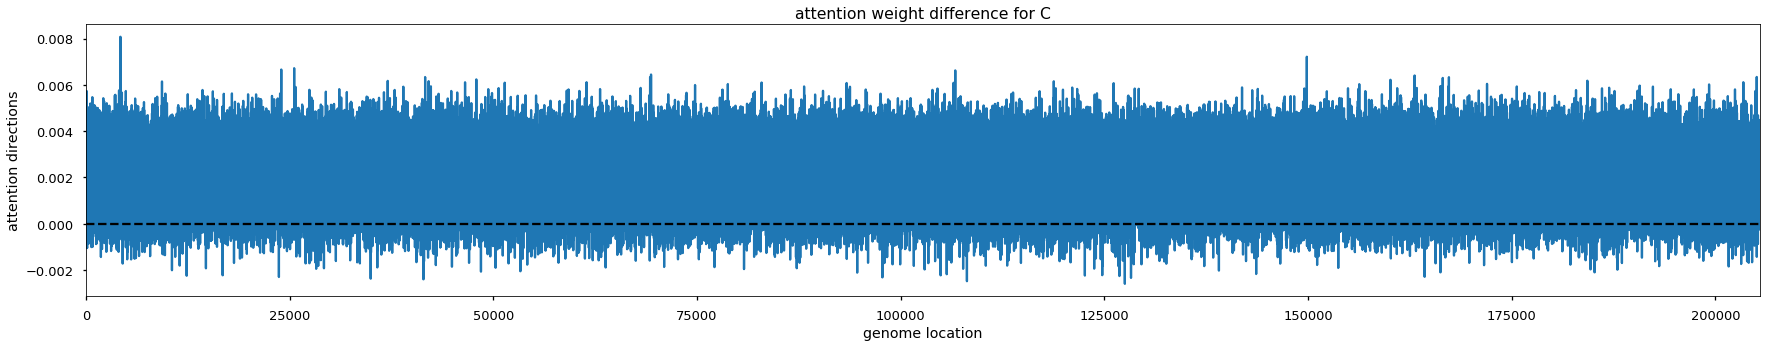

In [23]:
K_lookup_C = model.K(genome_C) 
V_lookup_C = model.V(genome_C) 
logits_C = model.Q(K_lookup_C) / math.sqrt(model.embedding_size)
probs_C = F.softmax(logits_C, dim = -1)    
X_C = probs_C * V_lookup_C
Y_C = model.W(X_C)

print(probs_C.shape)
print(Y_C.shape)

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention weights')
# plt.title('QK attention weights for C')
# plt.savefig('./C-attn-'+file_name+'.png')
# plt.show()

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('QKV attention weights for C')
# # plt.savefig('./C-Vatt-'+file_name+'.png')
# plt.show()

# for q in range(2):
#     plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,q], s=point_size, alpha=alpha_value)
# plt.legend({'normal','tumor'})
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('attention direction for C')
# plt.savefig('./C-dirc-'+file_name+'.png')
# plt.show()

# plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.plot(np.arange(GENOME_LENGTH), list(Y_C.data[:,0]-Y_C.data[:,1]))
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for C')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./C-diff-'+file_name+'.png')
plt.show()


torch.Size([205438, 20])
torch.Size([205438, 2])


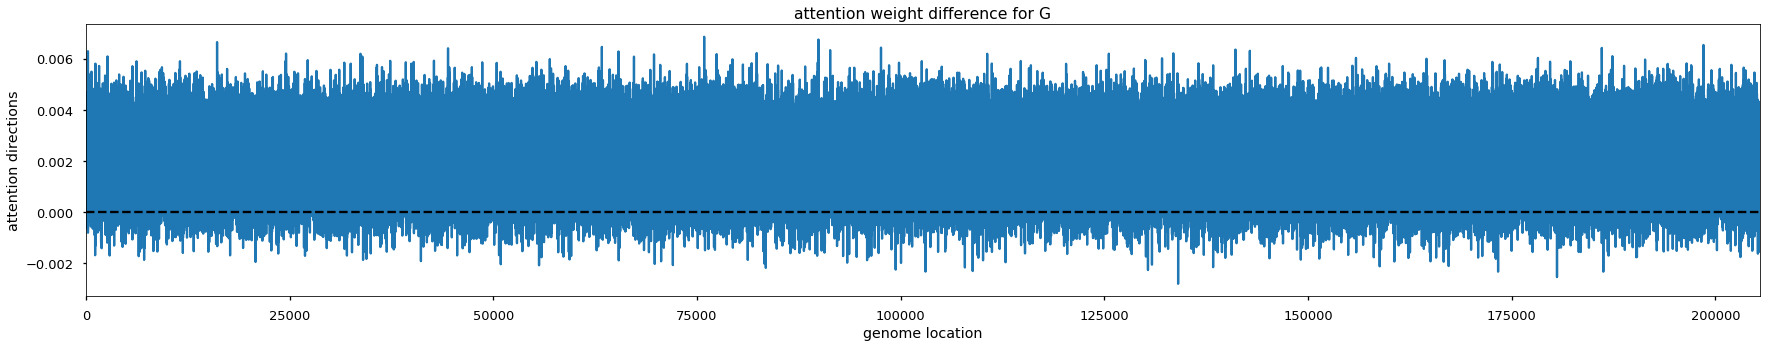

In [24]:
K_lookup_G = model.K(genome_G) 
V_lookup_G = model.V(genome_G) 
logits_G = model.Q(K_lookup_G) / math.sqrt(model.embedding_size)
probs_G = F.softmax(logits_G, dim = -1)    
X_G = probs_G * V_lookup_G
Y_G = model.W(X_G)

print(probs_G.shape)
print(Y_G.shape)

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention weights')
# plt.title('QK attention weights for G')
# plt.savefig('./G-attn-'+file_name+'.png')
# plt.show()

# for q in range(q_size):
#     plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value)
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('QKV attention weights for G')
# # plt.savefig('./G-Vatt-'+file_name+'.png')
# plt.show()

# for q in range(2):
#     plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,q], s=point_size, alpha=alpha_value)
# plt.legend({'normal','tumor'})
# plt.rcParams['figure.figsize'] = [width, height]
# plt.xlim(0, GENOME_LENGTH)
# plt.xlabel('genome location')
# plt.ylabel('attention directions')
# plt.title('attention direction for G')
# plt.savefig('./G-dirc-'+file_name+'.png')
# plt.show()

# plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.plot(np.arange(GENOME_LENGTH), list(Y_G.data[:,0]-Y_G.data[:,1]))
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for G')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./G-diff-'+file_name+'.png')
plt.show()


In [ ]:
# probs
# X
# Y
# Y_diff

muts = {'N': [probs_N.data, X_N.data, Y_N.data, Y_N.data[:,0]-Y_N.data[:,1]],
        'A': [probs_A.data, X_A.data, Y_A.data, Y_A.data[:,0]-Y_A.data[:,1]],
        'T': [probs_T.data, X_T.data, Y_T.data, Y_T.data[:,0]-Y_T.data[:,1]],
        'C': [probs_C.data, X_C.data, Y_C.data, Y_C.data[:,0]-Y_C.data[:,1]],
        'G': [probs_G.data, X_G.data, Y_G.data, Y_G.data[:,0]-Y_G.data[:,1]]}

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value, c='grey')
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value, c='orange')
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value, c='blue')
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value, c='green')
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value, c='purple')
    
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QK attention weights')
# plt.savefig('./attn-'+file_name+'.png')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value, c='grey')
    plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value, c='orange')
    plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value, c='blue')
    plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value, c='green')
    plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value, c='purple')

plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights')
# plt.savefig('./Vatt-'+file_name+'.png')
plt.axhline(y=0,ls='dashed',c='black')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='grey')
plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='grey')
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='orange')
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='orange')
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='blue')
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='blue')
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='green')
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='green')
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='purple')
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='purple')

# plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction')
# plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='grey', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='orange', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='blue', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='green', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='purple', s=point_size, alpha=alpha_value)
  
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./diff-'+file_name+'.png')   
plt.show()
